In [1]:
### Import packages

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_palette("Dark2")

from learnspec.functions import directories, stacking
from learnspec.src import load as loading
from learnspec.src import train as training
from learnspec.src import predict as prediction

# ### For ML
# import tensorflow as tf
# from tensorflow.keras import layers, Model

# ### Enforce full precision when using GPUs
# # tf.keras.backend.set_floatx('float32')


plt.style.use('/Users/aayushsaxena/Desktop/Oxford/plt_styles/as_jades.mplstyle')


In [ ]:
### List of all input redshift catalogues
all_redshifts = ["/Users/aayushsaxena/Desktop/Oxford/JADES/GS-HST-DEEP/visual_inspection_hst_gs_deep_v0.7.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-1287/visual_redshifts_consolidated_1287_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-3215/visual_redshifts_consolidated_ultra_deep_gs_3215_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-HST-MEDIUM/visual_redshifts_hst_medium_redo_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-JWST-MEDIUM-1180/visual_redshifts_JWST_Medium_1180_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GS-JWST-MEDIUM-1286/visual_redshifts_1286_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GN-HST-MEDIUM/visual_redshifts_consolidated_gn_hst_medium_1181_v0.6.csv",
"/Users/aayushsaxena/Desktop/Oxford/JADES/GN-JWST-MEDIUM/visual_redshifts_consolidated_gn_jwst_medium_1181_v0.6.csv"]

all_surveys = ['GS-HST-DEEP', 'GS-JWST-DEEP', 'GS-3215', 'GS-HST-MEDIUM', 'GS-JWST-MEDIUM-1180', 'GS-JWST-MEDIUM-1286', 'GN-HST-MEDIUM', 'GN-JWST-MEDIUM']

# Pre-processing of the data

In [ ]:
### It is possible to load in multiple redshift catalogues and combine them
### This is useful if you want to stack sources from multiple surveys
grating = "prism"

speclist = []
redshifts = []
for i in range(len(all_redshifts)):
    input_cat = pd.read_csv(all_redshifts[i])
    survey = all_surveys[i]
    redshift_range = (6,15)
    specdir, version = directories.translate_dir(survey, grating)
    speclist_temp, redshifts_temp = directories.select_sources(input_cat, specdir, redshift_range, grating, version)
    speclist.extend(speclist_temp)
    redshifts.extend(redshifts_temp)

redshifts = np.array(redshifts, dtype=float)
total_sources = len(speclist)
print(f"Number of sources with z > {redshift_range[0]} and z < {redshift_range[1]}: {total_sources}")

In [ ]:
# First step is to de-redshift, renormalize and resample all the spectra on to a common wavelength grid
# The renormalization for the majority of the spectra is done such that the flux at 1500A rest frame is set to 1
# For grating spectra, currently no renormalization is done
# Pick the desired resolution of the final stack
resolution = 3.0

if grating == 'prism':
    mean_stack, median_stack, std_stack, resampled_spec = stacking.sigma_clipped_stacking(speclist, redshifts, resolution=resolution, sigma=100.0)
    # mean_stack, resampled_spec = stacking.mean_stacking(speclist, redshifts, resolution=resolution)
else:
    mean_stack, median_stack, std_stack, resampled_spec = stacking.stack_grating(speclist, redshifts, grating=grating, resolution=resolution)


print("Spectra de-redshifted, renormalized and resampled")
print("Mean stack shape: ", mean_stack.shape)
print("Median redshift: ", np.median(redshifts))


In [ ]:
### Plot resampled spectra
plt.figure(figsize=(10, 6))
for i in range(len(resampled_spec)):
    plt.plot(resampled_spec[i].spectral_axis, resampled_spec[i].data, alpha=0.2, color='grey')


plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")
plt.ylim(-0.5, 2.5)
plt.show()

## Dimensionality reduction and clustering analysis on resampled spectra

### Pre-processing the data

In [2]:
### The pre-processed data sits in the `data` directory. Here we are using dja_z4-16 dataset
original_data, wavelength, redshifts, speclist = loading.load_data()

### Scale the data
resampled_data = loading.process_data(original_data, wavelength, scaler=True, scale_factor=1.0)
print("Data shape after scaling: ", resampled_data.shape)

### Print the total number of spectra
total_sources = len(resampled_data)
print(f"Number of sources: {total_sources}")

Transformed data saved to ../data/output/processed_spectra.npy
Data shape after scaling:  (3751, 2548)
Number of sources: 3751


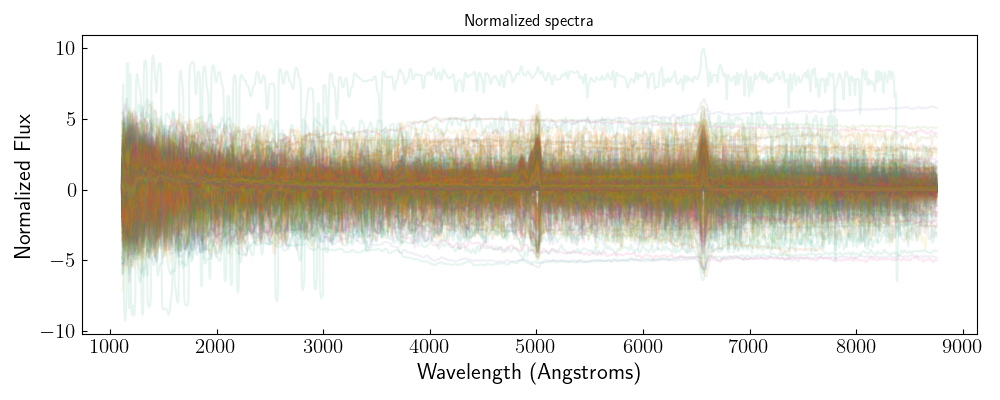

In [3]:
### Plot the normalized data
plt.close()
plt.figure(figsize=(10,4))
### Plot all spectra
plt.plot(wavelength, resampled_data.T, alpha=0.1)
### Only plot spectra with prominent negative values
# plt.plot(wavelength, spectra_denoised.T, alpha=0.1)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Normalized Flux")
plt.title("Normalized spectra")
plt.tight_layout()
plt.show()

In [7]:
### Print the summary statistics of the data
print(np.min(resampled_data), np.max(resampled_data), np.mean(resampled_data), np.std(resampled_data))

-9.257771786338237 9.984737390250583 0.22412487570747636 0.521161424363753


In [8]:
### Identify spectra that may have negative values
flagged_indices = loading.detect_negative_spikes(resampled_data, threshold=-3.0, prominence=0.2)
print(f"Number of flagged spectra: {len(flagged_indices)}")

Number of flagged spectra: 158


In [3]:
### Prepare the data for the VAE
# Set input dimensions
input_dim = training.get_input_dim(resampled_data)
print(f"Input dimension: {input_dim}")

### Set latent dimension
latent_dim = 16 

Input dimension: 2548


In [4]:
### Build the VAE model
initial_lr = 1e-4
vae_model = training.create_vae_model(input_dim, latent_dim, 
                                      initial_learning_rate=initial_lr)
vae_model.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 16), (None,    │     1,444,640 │
│                                 │ 16), (None, 16))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 2548)           │     1,443,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,887,700 (11.02 MB)

 Trainable params: 2,887,700 (11.02 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
### Train the VAE model
validation_split = 0.20
epochs = 1000
batch_size = 64
history = training.train_vae_model(vae_model, resampled_data, validation_split=validation_split, max_epochs=epochs, batch_size=batch_size)


Training Configuration:
Training samples: 3001
Validation samples: 750
Batch size: 64
Maximum epochs: 1000
Epoch 1/1000
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - kl_loss: 9.0491 - loss: 819.2756 - reconstruction_loss: 810.2266
Epoch 1: val_reconstruction_loss improved from inf to 381.37796, saving model to best_model.weights.h5
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - kl_loss: 9.6355 - loss: 813.3665 - reconstruction_loss: 803.7309 - val_kl_loss: 18.0231 - val_loss: 399.4011 - val_reconstruction_loss: 381.3780
Epoch 2/1000
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 21.6352 - loss: 500.8366 - reconstruction_loss: 479.2014
Epoch 2: val_reconstruction_loss improved from 381.37796 to 314.61349, saving model to best_model.weights.h5
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - kl_loss: 21.5184 - loss: 501.0063 - reconstruction_loss: 479.4879 - val_kl_loss: 15.4483 - val_loss: 330.0619 - val_reconstruction_loss: 314.6135
Epoch 3/1000
45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - kl_loss: 

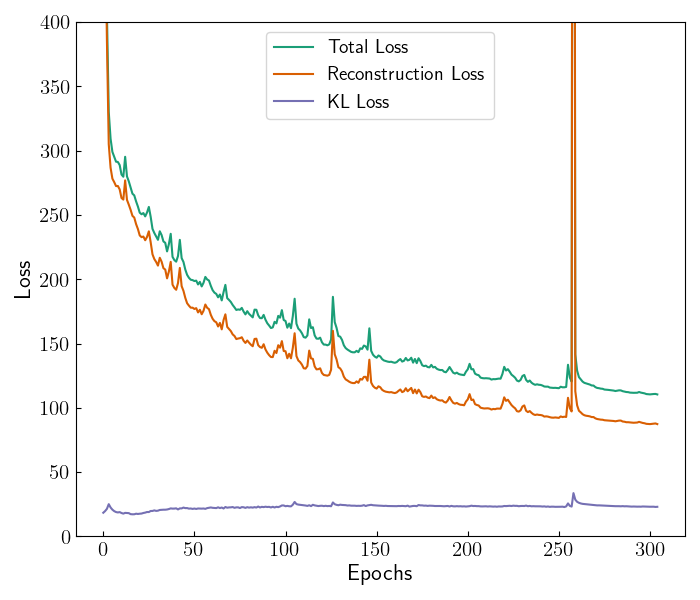

In [6]:
### Keep track of final validation loss at the end of training
model_history = history.history
loss = model_history['loss']
reconstruction_loss = model_history['reconstruction_loss']
kl_loss = model_history['kl_loss']

# final_loss_8dim = loss[-1]

### Plot the training loss
plt.close()
plt.figure(figsize=(7, 6))
plt.plot(loss, label='Total Loss')
plt.plot(reconstruction_loss, label='Reconstruction Loss')
plt.plot(kl_loss, label='KL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 400)
plt.legend(fontsize=14)
# plt.title('VAE Training Loss')
plt.tight_layout()
# plt.savefig("vae_training_loss.png", dpi=300)
plt.show()

### Save the model encoder and decoder

In [12]:
# Save the encoder and decoder separately
vae_model.encoder.save("../models/dja_z4_16_res3_dim16_vae_encoder.keras")
vae_model.decoder.save("../models/dja_z4_16_res3_dim16_vae_decoder.keras")

### Save the model weights

In [ ]:
### Save the trained model
# vae_model.save("../models/dja_z4_16_res3_dim16_vae_model_full.keras")
### Save the model in hdf5 format
# vae_model.save("../model/jades_z4_16_res3_vae_model_full.h5")  # HDF5 format

### Save the model weights
vae_model.build(input_shape=(None, input_dim))
vae_model.save_weights("../models/dja_z4_16_res3_dim16_vae_model.weights.h5")

### Load in the weights of the pre-trained model

In [ ]:
# Recreate the model and load weights
# First recreate your model structure exactly as before
vae_model = training.create_vae_model(input_dim, latent_dim)
# Then load weights
vae_model.build(input_shape=(None, input_dim))
vae_model.load_weights("../models/dja_z4_16_res3_dim16_vae_model.weights.h5")

/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Predict the spectra for our own data

In [7]:
### Extract the latent space representation
z_mean, z_log_var, z = prediction.evaluate_latent_space(vae_model.encoder, resampled_data)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


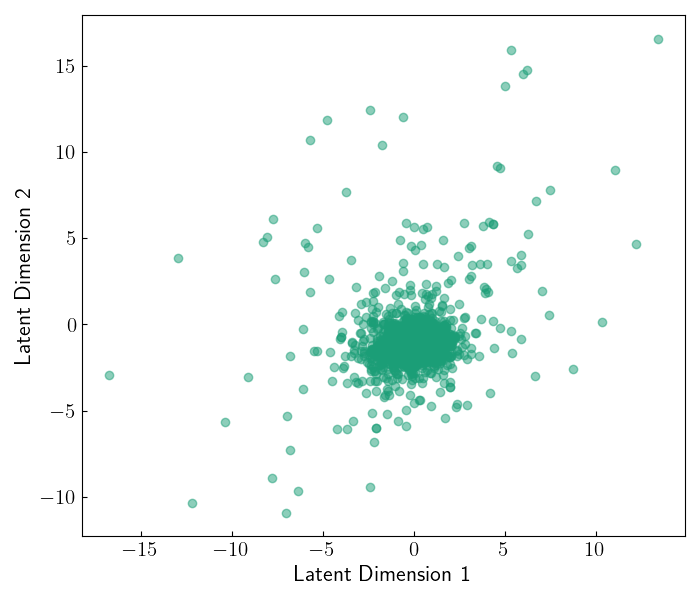

In [8]:
### Visualize the latent space
plt.close()
plt.figure(figsize=(7, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
# plt.title("Latent Space Representation")
plt.tight_layout()
plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


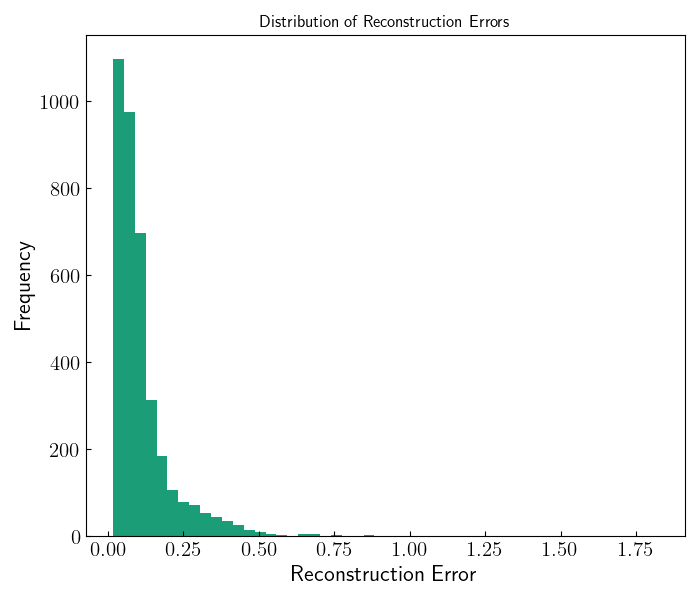

In [9]:
### Reconstruction errors
# Compute reconstruction errors
reconstructed_spectra = prediction.reconstruct_spectra(vae_model.decoder, z_mean)
reconstruction_errors = prediction.calculate_reconstruction_error(resampled_data, reconstructed_spectra)

# Plot reconstruction errors
plt.close()
plt.figure(figsize=(7, 6))
plt.hist(reconstruction_errors, bins=50)
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.tight_layout()
# plt.savefig("reconstruction_errors.png", dpi=300)
plt.show()


Sample index: 2086


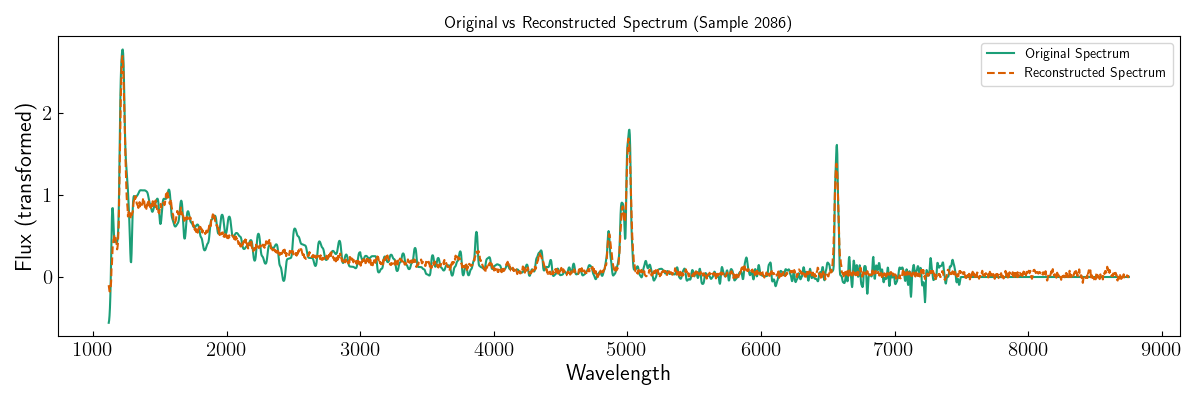

In [89]:
### Visualize specific spectra
# Select a random sample from the data
sample_idx = np.random.randint(len(resampled_data))

# Visualise the source with the second highest reconstruction error
# sample_idx = np.argmax(reconstruction_errors)
# sample_idx = np.argsort(reconstruction_errors)[-13]

### POick the sample spectrum and its corresponding reconstructed spectrum
sample_spectrum = resampled_data[sample_idx]
reconstructed_spectrum = reconstructed_spectra[sample_idx]
print(f"Sample index: {sample_idx}")
# print(f"Reconstruction error: {reconstruction_errors[sample_idx]}")

# Plot original vs reconstructed spectrum
plt.close()
plt.figure(figsize=(12, 4))
plt.plot(wavelength, sample_spectrum, label="Original Spectrum")
plt.plot(wavelength, reconstructed_spectrum, label="Reconstructed Spectrum", linestyle="--")
plt.title(f"Original vs Reconstructed Spectrum (Sample {sample_idx})")
plt.xlabel("Wavelength")
plt.ylabel("Flux (transformed)")
plt.legend()
plt.tight_layout()
plt.show()

Sample indices: [np.int64(3643), np.int64(3181), np.int64(1048), np.int64(1214)]
Reconstruction errors: [0.04274564 0.06810853 0.11019385 0.33382305]


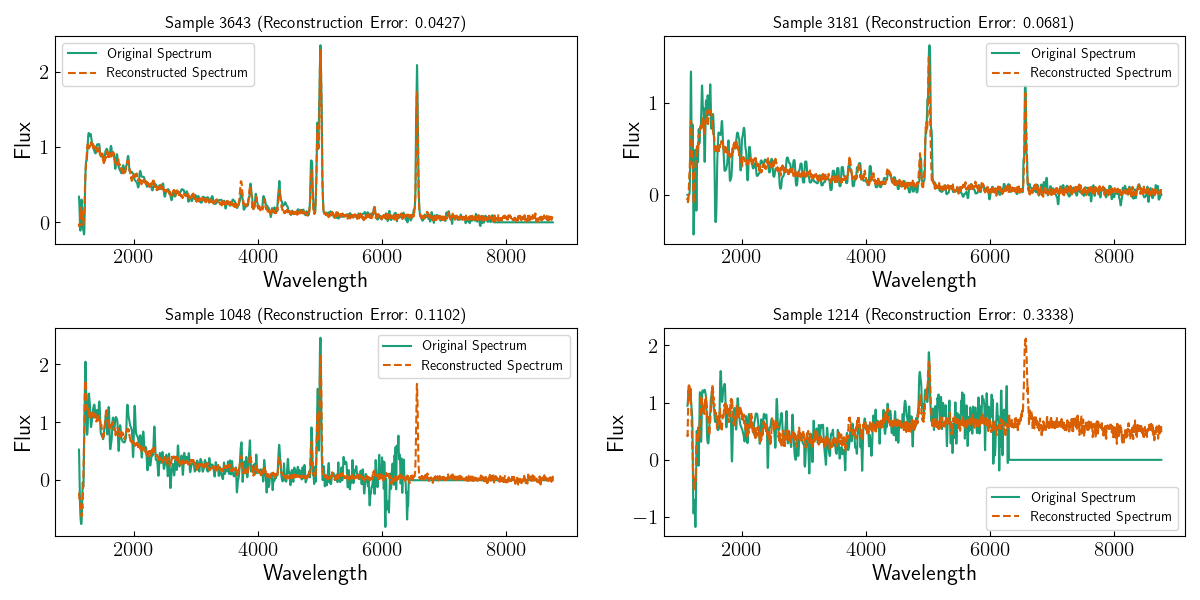

In [21]:
### Create a gallery of four reconstructed spectra, randomly sampled from four quantiles of the reconstruction error distribution
quantiles = np.percentile(reconstruction_errors, [0, 25, 50, 75, 100])
sample_indices = []
for i in range(len(quantiles) - 1):
    lower_bound = quantiles[i]
    upper_bound = quantiles[i + 1]
    indices = np.where((reconstruction_errors >= lower_bound) & (reconstruction_errors < upper_bound))[0]
    if len(indices) > 0:
        sample_indices.append(np.random.choice(indices))
    else:
        sample_indices.append(np.random.choice(len(resampled_data)))
print(f"Sample indices: {sample_indices}")
print(f"Reconstruction errors: {reconstruction_errors[sample_indices]}")
# Plot original vs reconstructed spectra for the selected indices
plt.close()
plt.figure(figsize=(12, 6))
for i, sample_idx in enumerate(sample_indices):
    plt.subplot(2, 2, i + 1)
    plt.plot(wavelength, resampled_data[sample_idx], label="Original Spectrum")
    plt.plot(wavelength, reconstructed_spectra[sample_idx], label="Reconstructed Spectrum", linestyle="--")
    plt.title(f"Sample {sample_idx} (Reconstruction Error: {reconstruction_errors[sample_idx]:.4f})")
    plt.xlabel("Wavelength")
    plt.ylabel("Flux")
    plt.legend()
plt.tight_layout()

# plt.savefig("reconstructed_spectra_gallery.png", dpi=300)
plt.show()

## Clustering!

In [22]:
from learnspec.src import cluster as clustering
from sklearn.mixture import GaussianMixture

In [19]:
### Bechmark clustering algorithms
### Benchmark in UMAP space
# results_umap = clustering.benchmark_clustering(z_mean, name="UMAP projection (16D)")
### Benchmark in latent space
results_latent = clustering.benchmark_clustering(z_mean, name="Latent space (16D)")

/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



 Clustering results for Latent space (16D):
KMeans: Silhouette = 0.081, DB = 2.347
GMM: Silhouette = -0.058, DB = 5.988
DBSCAN: Silhouette = 0.214, DB = 0.814
HDBSCAN: Silhouette = 0.175, DB = 0.930


In [ ]:
### Perform clustering in latent space

### cluster the latent space using Gaussian Mixture Model
n_clusters = 10  # Set the number of clusters
cluster_labels = clustering.cluster_latent_space_gmm(z_mean, n_components=n_clusters)

### cluster the latent space using hdbscan
# n_clusters_hdbscan = 10  # Set the number of clusters
# cluster_labels_hdbscan = clustering.cluster_latent_space_hdbscan(z_mean, n_clusters=n_clusters_hdbscan)

/Users/aayushsaxena/Desktop/Oxford/python_envs/neuralnet/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


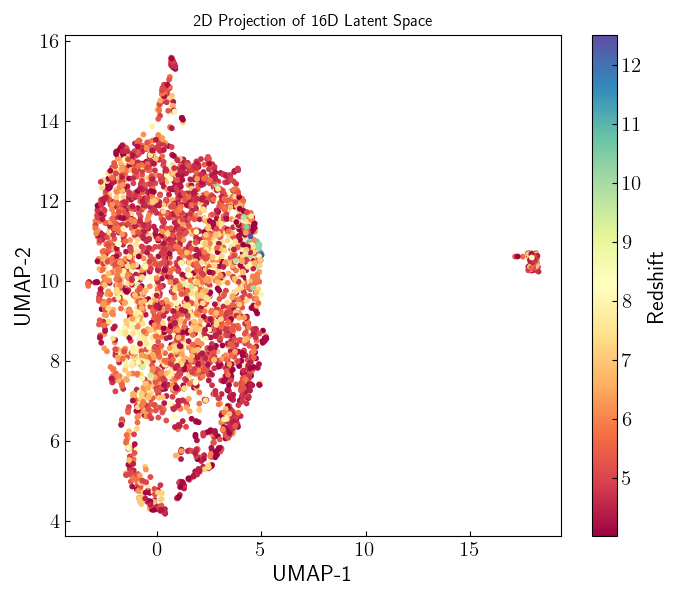

In [109]:
# Use UMAP to reduce the latent space to 2D
n_neighbours = 5
min_dist = 0.1
z_2d = clustering.umap_latent_space(z_mean, n_neighbors=n_neighbours, min_dist=min_dist)

# Plot the 2D latent space
plt.close()
plt.figure(figsize=(7, 6))
# plt.scatter(z_2d[:, 0], z_2d[:, 1], c=np.arange(len(z_2d)), cmap='Spectral', s=10)
plt.scatter(z_2d[:, 0], z_2d[:, 1], c=redshifts, cmap='Spectral', s=10)
plt.colorbar(label="Redshift")
plt.title("2D Projection of 16D Latent Space")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.savefig("./plots/UMAP_projection.png", dpi=300)
plt.show()

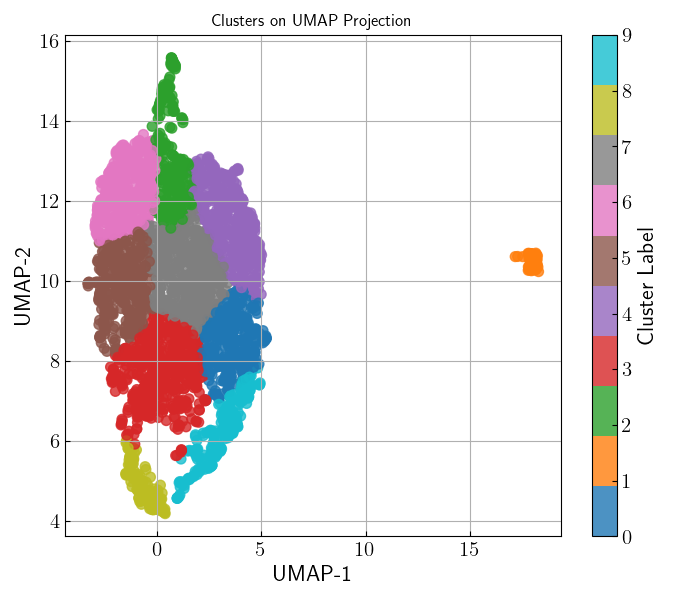

In [110]:
### Let's perform some clustering on the UMAP output using HDBSCAN
### Use GMM 
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=10, covariance_type='full')
cluster_labels = gmm.fit_predict(z_2d)

# Plotting
plt.close()
plt.figure(figsize=(7, 6))
plt.scatter(z_2d[:, 0], z_2d[:, 1],
            c=cluster_labels, cmap='tab10', s=50, alpha=0.8)
plt.title('Clusters on UMAP Projection')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
# plt.xlim(-5,5)
plt.tight_layout()
plt.savefig("./plots/UMAP_clusters.png", dpi=300)
plt.show()

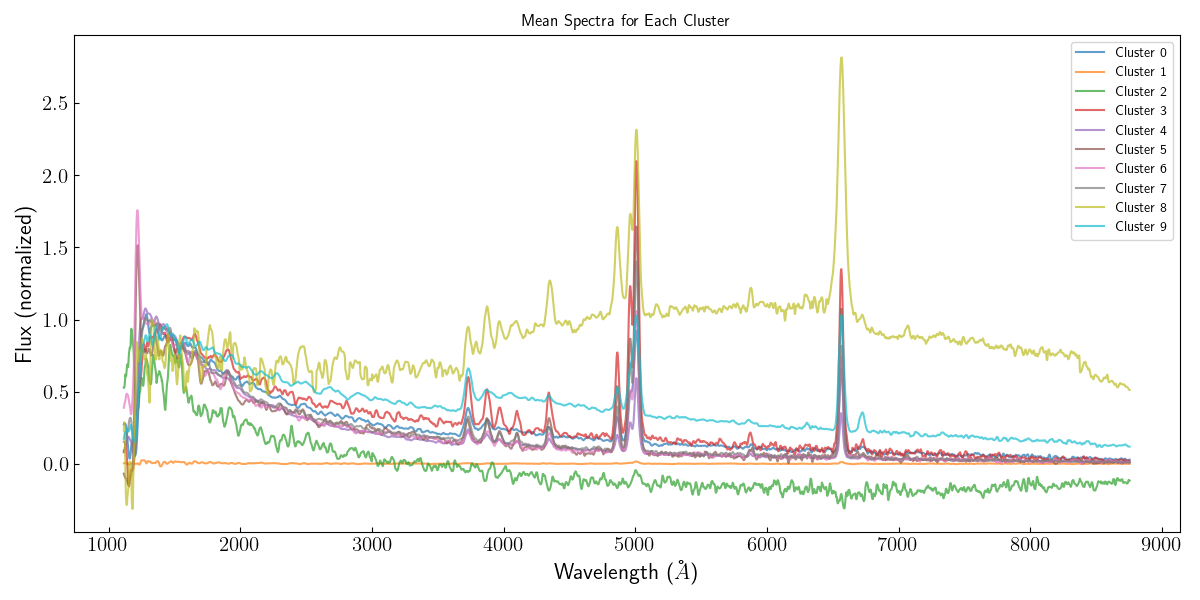

In [112]:
### Let's produce a mean spectrum per cluster
unique_labels = np.unique(cluster_labels)
# n_clusters = len(unique_labels[unique_labels != -1])  # excluding noise if any
n_clusters = len(unique_labels)

plt.close()
plt.figure(figsize=(12, 6))

for i, label in enumerate(unique_labels):
    # if label == -1:
    #     continue  # skip noise
    cluster_spectra = resampled_data[cluster_labels == label]
    mean_spectrum = np.mean(cluster_spectra, axis=0)
    ### Give the same color to the cluster
    color = sns.color_palette("tab10", n_colors=n_clusters)[i]
    plt.plot(wavelength, mean_spectrum, label=f'Cluster {label}', color=color, alpha=0.7)

plt.title("Mean Spectra for Each Cluster")
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel("Flux (normalized)")

# plt.yscale('log')
# plt.ylim(5e5, 1e8)
# plt.ylim(-10,10)
plt.legend()
plt.tight_layout()
plt.savefig("./plots/Cluster_mean_spectra.png", dpi=300)
plt.show()

In [71]:
### Print the number of sources in each cluster
for label in unique_labels:
    n_sources = np.sum(cluster_labels == label)
    print(f"Cluster {label}: {n_sources} sources")

Cluster 0: 398 sources
Cluster 1: 182 sources
Cluster 2: 665 sources
Cluster 3: 160 sources
Cluster 4: 577 sources
Cluster 5: 228 sources
Cluster 6: 318 sources
Cluster 7: 440 sources
Cluster 8: 308 sources
Cluster 9: 475 sources


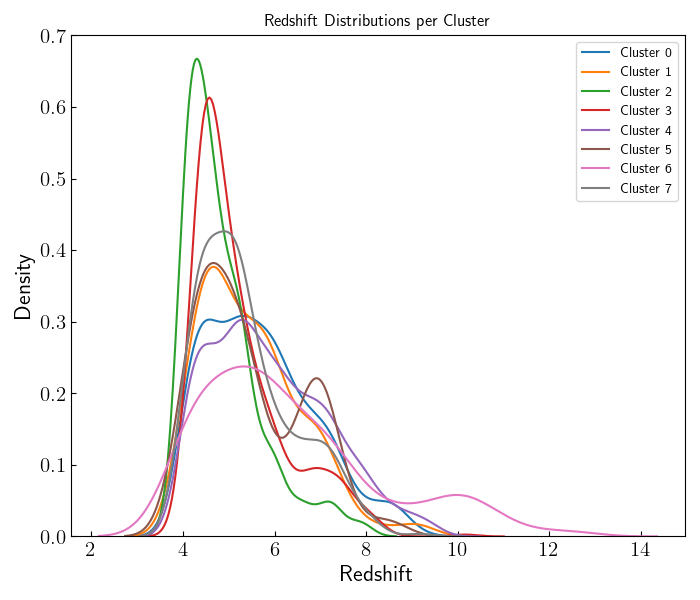

In [30]:
### Redshift distribution per cluster
plt.close()
plt.figure(figsize=(7, 6))
for i, label in enumerate(unique_labels):
    # if label == -1:
    #     continue
    color = sns.color_palette("tab10", n_colors=n_clusters)[i]
    z_vals = redshifts[cluster_labels == label]
    sns.kdeplot(z_vals, color=color, label=f"Cluster {label}")

plt.title("Redshift Distributions per Cluster")
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

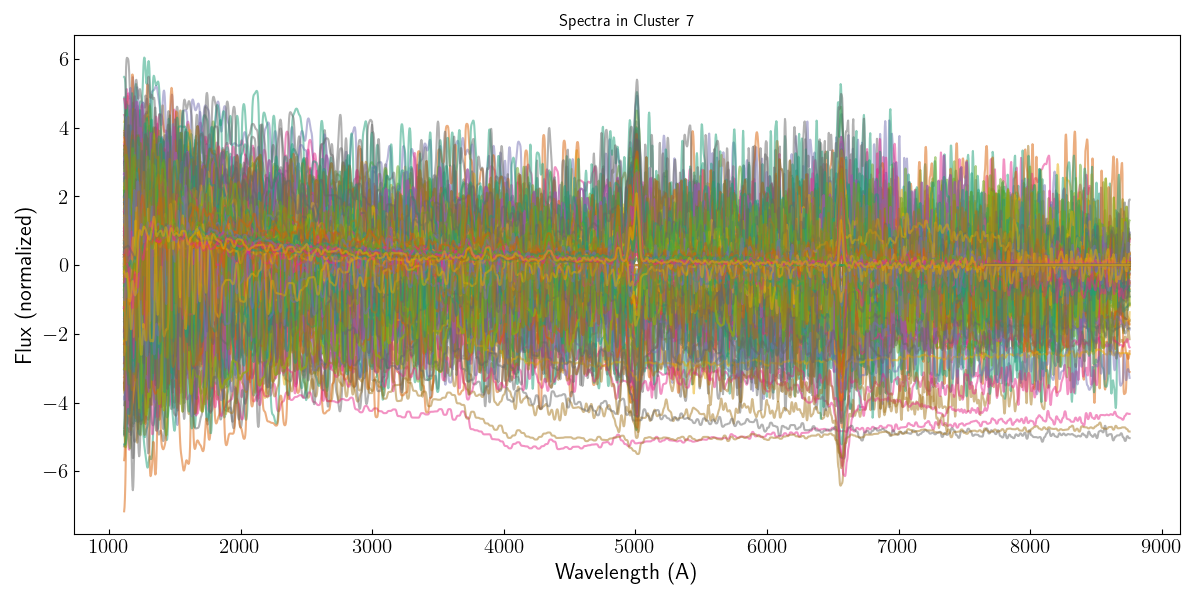

In [42]:
### Let us now analyze the actual input spectra in each cluster


### Plot spectra for cluster 5
cluster_label = 7
cluster_spectra = resampled_data[cluster_labels == cluster_label]
clustering.plot_cluster_spectra(cluster_label, cluster_spectra, wavelength)


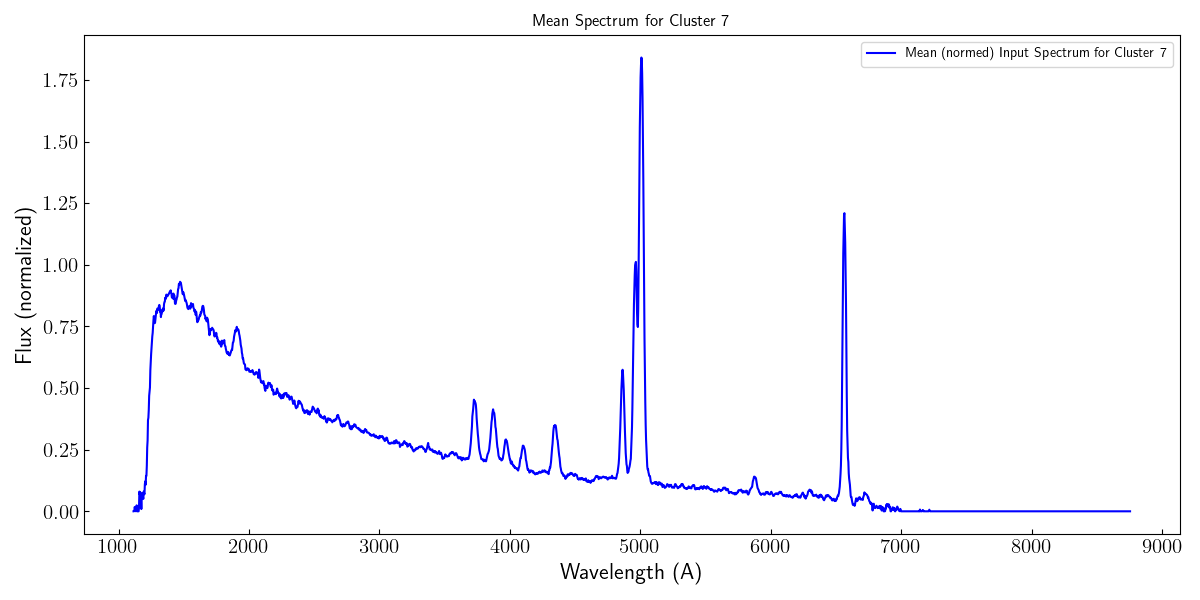

In [43]:
### Plot the mean spectrum from the resampled_data for a given cluster
# cluster_label = 2
mean_spectrum = np.median(cluster_spectra, axis=0)
plt.close()
plt.figure(figsize=(12, 6))
plt.plot(wavelength, mean_spectrum, label=f'Mean (normed) Input Spectrum for Cluster {cluster_label}', color='blue')
plt.title(f"Mean Spectrum for Cluster {cluster_label}")
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux (normalized)")
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
### Print the information from "speclist" for the sources in the cluster
cluster_indices = np.where(cluster_labels == cluster_label)[0]
print(f"Number of sources in cluster {cluster_label}: {len(cluster_indices)}")
for idx in cluster_indices:
    source_id = speclist[idx]
    redshift = redshifts[idx]
    print(f"Source ID: {source_id}, Redshift: {redshift:.2f}")

### Output the cluster information to a text file
output_file = f"cluster_{cluster_label}_info.txt"
with open(output_file, 'w') as f:
    f.write(f"Cluster {cluster_label} Information:\n")
    f.write(f"Number of sources: {len(cluster_indices)}\n")
    for idx in cluster_indices:
        source_id = speclist[idx]
        redshift = redshifts[idx]
        f.write(f"Source ID: {source_id}, Redshift: {redshift:.2f}\n")
print(f"Cluster information saved to {output_file}")

Number of sources in cluster 2: 150
Source ID: /Volumes/data5tb/DJA_JWST/capers-udsp1-v3/prism_clear/capers-udsp1-v3_prism-clear_6368_23419.spec.fits, Redshift: 5.52
Source ID: /Volumes/data5tb/DJA_JWST/capers-udsp2-v3/prism_clear/capers-udsp2-v3_prism-clear_6368_10997.spec.fits, Redshift: 5.16
Source ID: /Volumes/data5tb/DJA_JWST/ceers-ddt-v3/prism_clear/ceers-ddt-v3_prism-clear_2750_1768.spec.fits, Redshift: 5.09
Source ID: /Volumes/data5tb/DJA_JWST/ceers-v3/prism_clear/ceers-v3_prism-clear_1345_1244.spec.fits, Redshift: 4.48
Source ID: /Volumes/data5tb/DJA_JWST/ceers-v3/prism_clear/ceers-v3_prism-clear_1345_20.spec.fits, Redshift: 7.77
Source ID: /Volumes/data5tb/DJA_JWST/ceers-v3/prism_clear/ceers-v3_prism-clear_1345_2782.spec.fits, Redshift: 5.25
Source ID: /Volumes/data5tb/DJA_JWST/ceers-v3/prism_clear/ceers-v3_prism-clear_1345_749.spec.fits, Redshift: 7.09
Source ID: /Volumes/data5tb/DJA_JWST/ceers-v3/prism_clear/ceers-v3_prism-clear_1345_80457.spec.fits, Redshift: 4.22
Source I

## Tests for optimal parameter choices for the VAE pipeline

In [ ]:
### Plot reconstriction losses vs number of latent dimensions
losses = np.array([final_loss_4dim, final_loss_8dim, final_loss_16dim, final_loss_32dim])
latent_dimensions = np.array([4, 8, 16, 32])
plt.close()
plt.figure(figsize=(7, 6))
plt.scatter(latent_dimensions, losses, marker='o', s=300, ec='k', zorder=10)
plt.axhline(y=np.min(losses), color='grey', linestyle='--')
plt.xlabel("Latent Dimensions")
plt.ylabel("Reconstruction Loss")
# plt.title("Reconstruction Loss vs Latent Dimensions")
# plt.xscale('log')
# plt.yscale('log')
plt.xticks(latent_dimensions)
# plt.yticks([10, 100, 300])
# plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_loss_vs_latent_dimensions.png", dpi=300)
plt.show()

In [ ]:
### Start by exploring KL losses per latent dimension
kl_per_dim_16 = np.mean(z_log_var - tf.math.log(tf.exp(z_log_var) + 1), axis=0)
print("KL losses per dimension: ", kl_per_dim_16)